In [1]:
import sys, os
sys.path.append(sys.path[0][:sys.path[0].rfind('/')])
import torch
from mirtorch.prox import prox
from mirtorch.linear import *
from mirtorch.alg import *
from mirtorch.alg.fista import FISTA
from mirtorch.alg.pogm import POGM
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize, scale
import matplotlib.pyplot as plt
import matplotlib

70000
7141
6313
13454
(13454, 784) (13454,)
Expected digit 5.0


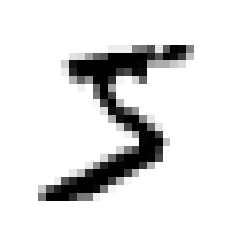

In [2]:
#Binary classification on MNIST digits using FISTA (specifically 3 and 5)
#get dataset
try:
    X,y = X_orig, y_orig
except:
    X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)

y = y.astype(np.float64)
X_orig, y_orig = X, y
print(len(X))
print(len(X[y==3]))
print(len(X[y==5]))
print(len(X[(y==3) | (y==5)]))

def show_digit(X, y):
    digit_image = X.reshape(28,28)
    print(f'Expected digit {y+4}')
    plt.imshow(digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
    plt.axis("off")
    plt.show()
#reduce data to be binary classification for simplicity
X, y = X[(y==3) | (y==5)], y[(y==3) | (y==5)]
y = y - 4
print(X.shape, y.shape)
show_digit(X[0], y[0])
#create train/test sets
X = normalize(X, axis=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=10000, test_size=3454)
X_train, X_test, y_train, y_test = torch.from_numpy(X_train), torch.from_numpy(X_test), torch.from_numpy(y_train), torch.from_numpy(y_test)

In [3]:
"""
Let's solve 
A'*Ax = y with CG (because A'*A is PSD)
Let's solve
argmin_x ||Ax-y|| + g(x) with FISTA/FPGM and POGM where grad(||Ax-y||) is L-lipshitz continuous and g(x) is a proximal operator
"""
def eval(x):
    # helper function to evaluate our results on the test data
    res = torch.matmul(X_test, x)
    res = torch.sign(res)
    res *= y_test
    total = res.shape[0]
    correct = res[res>0].shape[0]
    #print(f'\tCorrect {correct} out of {total} total')
    return correct, total

class A(LinearMap):
    def __init__(self):
        self._A = X_train.clone()
        super().__init__([28*28], [10000])
    def _apply(self, x):
        return torch.matmul(self._A, x)
    def _apply_adjoint(self, x):
        return torch.matmul(self._A.T, x)

class gradA:
    def __init__(self):
        self.A_mat = A()
    def __call__(self,x):
        return self.A_mat.H * (self.A_mat * x - y_train)



In [4]:
"""
Solve CG
"""
cgs = []
a_mat = A()
for i in range(1, 300, 5):
    cg = CG(A=a_mat.H*a_mat, max_iter=i).run(x0=torch.zeros(28*28,dtype=torch.double), b=a_mat.H(y_train))
    h = eval(cg)
    cgs.append(h[0]/h[1])

In [5]:
"""
Solve FISTA
"""
fsta = []
L = torch.linalg.norm(X_train, ord=2)**2
for i in range(1, 300, 5):
    fs = FISTA(f_grad=gradA(), f_L=L, g_prox=prox.L1Regularizer(1e-3), max_iter=i).run_alg(x0=torch.zeros(28*28, dtype=torch.double))
    f = eval(fs)
    fsta.append(f[0]/f[1])

In [6]:
"""
Solve POGM
"""
pogm = []
for i in range(1, 300, 5):
    pg = POGM(f_grad=gradA(), f_L=L, g_prox=prox.L1Regularizer(1e-3), max_iter=i).run_alg(x0=torch.zeros(28*28, dtype=torch.double))
    p = eval(pg)
    pogm.append(p[0]/p[1])

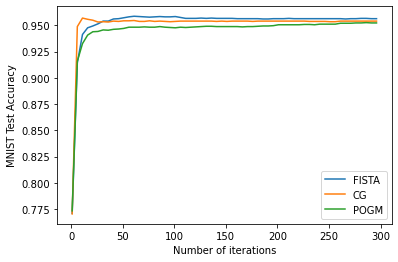

In [7]:
plt.plot([i for i in range(1, 300, 5)], fsta, label='FISTA')
plt.plot([i for i in range(1, 300, 5)], cgs, label='CG')
plt.plot([i for i in range(1, 300, 5)], pogm, label='POGM')
plt.legend()
plt.xlabel('Number of iterations')
plt.ylabel('MNIST Test Accuracy')
plt.show()

In [8]:
"""
Verify that CG/FSTA/POGM is differentiable
"""
cg = CG(A=a_mat.H*a_mat, max_iter=10).run(x0=torch.zeros(28*28,dtype=torch.double,requires_grad=True), b=a_mat.H(y_train))
torch.sum(cg).backward()
fs = FISTA(f_grad=gradA(), f_L=L, g_prox=prox.L1Regularizer(1e-3), max_iter=10).run_alg(x0=torch.zeros(28*28, dtype=torch.double, requires_grad=True))
torch.sum(fs).backward()
pg = POGM(f_grad=gradA(), f_L=L, g_prox=prox.L1Regularizer(1e-3), max_iter=10).run_alg(x0=torch.zeros(28*28, dtype=torch.double, requires_grad=True))
torch.sum(pg).backward()

